In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp

plt.style.use("seaborn-v0_8-whitegrid") 
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2,
})

### Gillespie's Algorithm

In [2]:
import numpy as np
from scipy.integrate import solve_ivp

def sir_rhs(t, y, beta, gamma,mu, N):
    """
    Frequency-dependent SIR with COUNTS (X,Y,Z) and fixed population N.
    dX/dt = -beta * X * Y / N
    dY/dt =  beta * X * Y / N - gamma * Y
    dZ/dt =  gamma * Y
    """
    X, Y, Z = y
    
    dX = mu * N - beta * X * Y / N - mu * X
    dY = beta * X * Y / N - gamma * Y - mu * Y
    dZ = gamma * Y - mu * Z
    return [dX, dY, dZ]
    


def integrate_sir(beta, gamma, mu, N, X0, Y0, Z0,
                         t_span=(0.0, 160.0), num_points=1000, method="RK45"):
    """
    Minimal integrator wrapper for counts-based frequency-dependent SIR.
    Returns dict with t, X, Y, Z (arrays).
    """

    y0 = [float(X0), float(Y0), float(Z0)]
    t_eval = np.linspace(t_span[0], t_span[1], num_points)

    sol = solve_ivp(
        lambda t, y: sir_rhs(t, y, beta, gamma, mu, N),
        t_span, y0, t_eval=t_eval, method=method,
        rtol=1e-8, atol=1e-10
    )

    # Numerical safety: clip tiny negatives from solver noise
    
    Y = np.clip(sol.y, 0.0, None)
    return {"t": sol.t, "X": Y[0], "Y": Y[1], "Z": Y[2]}


def gillespie_sir(beta, gamma, mu, N, X0, Y0, Z0, tmax, rng=None):
    """
    infectionL (X - 1, Y + 1), rate_1 = beta * X * Y / N
    recovery: (Y - 1, Z + 1), rate_2 = gamma * Y
    birth:  (X + 1), rate_3 = mu * N
    deathX: (X - 1), rate_4 = mu * X
    deathY: (Y - 1), rate_5 = mu * Y
    deathZ: (Z - 1), rate_6 = mu * Z
    """
    if rng is None:
        rng = np.random.default_rng()

    # Validate & coerce to ints
    
    X, Y, Z = int(X0), int(Y0), int(Z0)
    t = 0.0
    
    times = [0.0]
    X_hist, Y_hist, Z_hist = [X], [Y], [Z]

    while t < tmax and Y > 0:
        rate_I = beta * X * Y / N   # infection
        rate_R = gamma * Y
        rate_B = mu * N              # birth
        rate_DX = mu * X             # death of susceptible
        rate_DY = mu * Y             # death of infected
        rate_DZ = mu * Z             # death of recovered
        total_rate = rate_I + rate_R + rate_B + rate_DX + rate_DY + rate_DZ

        # exponential waiting time
        t += -np.log(rng.random()) /  total_rate

        r  = rng.random() * total_rate
        
        if r < rate_I:
            if X > 0: X -= 1; Y += 1
        elif r < rate_I + rate_R:
            if Y > 0: Y -= 1; Z += 1
        elif r < rate_I + rate_R + rate_B:
            X += 1
        elif r < rate_I + rate_R + rate_B + rate_DX:
            if X > 0: X -= 1
        elif r < rate_I + rate_R + rate_B + rate_DX + rate_DY:
            if Y > 0: Y -= 1
        else:
            if Z > 0: Z -= 1

        times.append(t); X_hist.append(X);Y_hist.append(Y);Z_hist.append(Z)

    return np.array(times), np.array(X_hist), np.array(Y_hist), np.array(Z_hist)


In [3]:
def resample_step(times, values, t_grid):
    """Piecewise-constant resampling of an event-driven trajectory."""
    
    out = np.empty_like(t_grid, dtype=float)
    j = 0
    curr = values[0]
    for k, tk in enumerate(t_grid):
        while j + 1 < len(times) and times[j + 1] <= tk:
            j += 1
            curr = values[j]
        out[k] = curr
    return out

In [74]:
# Compare stochastic and deterministic SIR models

beta = 0.5
gamma = 0.1
mu = 1/50
N = 1000
I0 = 10
S0 = N - I0
R0 = 0

t_span = (0.0, 160.0)
num_points = 1000
t_grid = np.linspace(t_span[0], t_span[1], num_points)

# Deterministic solution
det = integrate_sir(beta, gamma, mu, N, S0, I0, R0,
                        t_span=t_span, num_points=num_points)

# Stochastic replicates
n_runs = 200
I_paths = np.zeros((n_runs, num_points), dtype=float)

for r in range(n_runs):
    rng = np.random.default_rng(12345 + r)  # reproducible variety
    times, S_hist, I_hist, R_hist = gillespie_sir(
        beta, gamma, mu, N, S0, I0, R0, tmax=t_span[1], rng=rng
    )
    I_paths[r, :] = resample_step(times, I_hist, t_grid)

I_mean = I_paths.mean(axis=0)

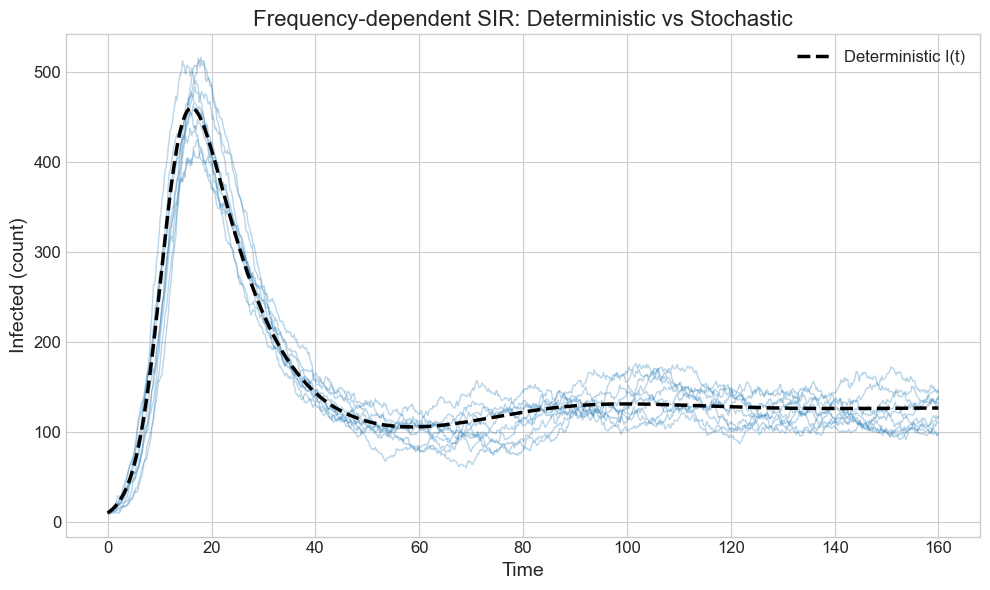

In [75]:
n_show = 10 # number of stochastic runs to show

fig, ax = plt.subplots()
for r in range(n_show):
    ax.plot(t_grid, I_paths[r, :], color="tab:blue", alpha=0.3, lw=1)

# Deterministic
ax.plot(det["t"], det["Y"], "k--", lw=2.5, label="Deterministic I(t)")

# Labels and legend
ax.set_xlabel("Time")
ax.set_ylabel("Infected (count)")
ax.set_title("Frequency-dependent SIR: Deterministic vs Stochastic")
ax.legend()

plt.tight_layout()
plt.show()

### Simulation Variability and Negative Co-variance

In [66]:
def run_ensemble(beta, gamma, mu, N, X0, Y0, Z0,
                 t_span=(0.0, 160.0), num_points=1000,
                 n_runs=200, seed0=12345):
    """
    Runs many Gillespie simulations and the deterministic ODE
    using counts (X,Y,Z). Returns t grid, deterministic curves,
    and stacked X/Y/Z paths.
    """
    # Use the counts-based integrator so keys are X,Y,Z
    det = integrate_sir(beta, gamma, mu, N, X0, Y0, Z0,
                               t_span=t_span, num_points=num_points)
    t_grid = det["t"]

    X_paths = np.zeros((n_runs, num_points))
    Y_paths = np.zeros((n_runs, num_points))
    Z_paths = np.zeros((n_runs, num_points))

    for r in range(n_runs):
        rng = np.random.default_rng(seed0 + r)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax=t_span[1], rng=rng
        )
        X_paths[r, :] = resample_step(times, X_hist, t_grid)
        Y_paths[r, :] = resample_step(times, Y_hist, t_grid)
        Z_paths[r, :] = resample_step(times, Z_hist, t_grid)

    return t_grid, det, X_paths, Y_paths, Z_paths


In [67]:
def ensemble_stats(X_paths, Y_paths, Z_paths):
    """Compute time-wise mean/variance for X, Y, Z, and Cov[X,Y] (counts)."""
    X_mean = X_paths.mean(axis=0)
    Y_mean = Y_paths.mean(axis=0)
    Z_mean = Z_paths.mean(axis=0)

    X_var  = X_paths.var(axis=0, ddof=1)
    Y_var  = Y_paths.var(axis=0, ddof=1)
    Z_var  = Z_paths.var(axis=0, ddof=1)

    XY_mean = (X_paths * Y_paths).mean(axis=0)
    XY_cov  = XY_mean - X_mean * Y_mean

    return {
        "X_mean": X_mean, "Y_mean": Y_mean, "Z_mean": Z_mean,
        "X_var": X_var,   "Y_var": Y_var,   "Z_var": Z_var,
        "XY_cov": XY_cov
    }

In [68]:
from math import ceil

beta = 0.5
gamma = 0.1
mu = 1/50
t_span = (0, 160)
num_points = 1000
n_runs = 200

N_list = [500, 1000, 2000, 5000, 10000]
I0_fixed = 5
i0_frac = I0_fixed / 5000

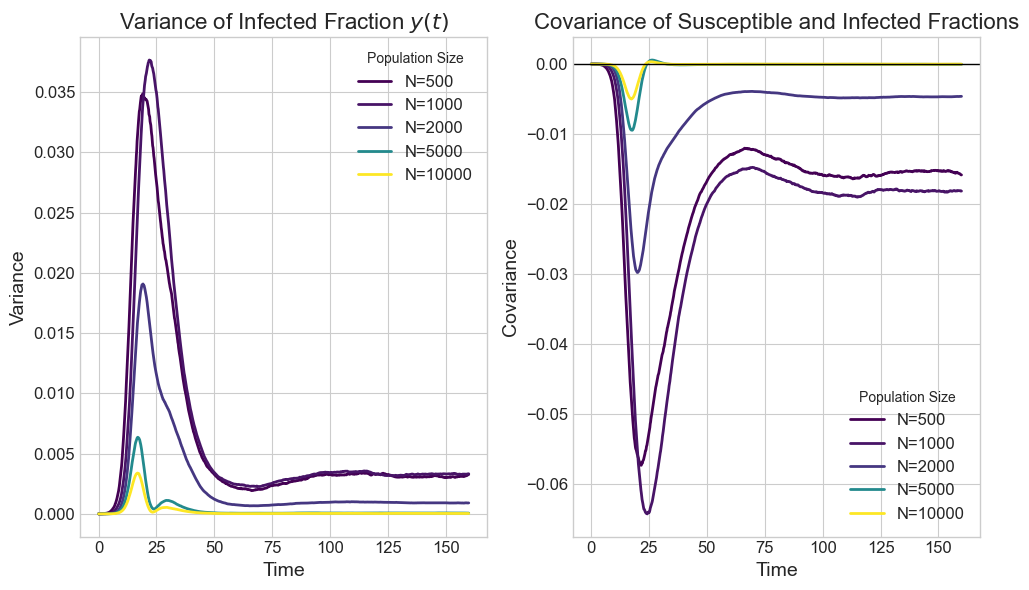

In [70]:
fig, (ax_var, ax_cov) = plt.subplots(1, 2)

Nmin, Nmax = min(N_list), max(N_list)

for N in N_list:
    # fixed initial fraction
    Y0 = max(1, int(ceil(i0_frac * N)))
    X0, Z0 = N - Y0, 0

    t, det, X_paths, Y_paths, Z_paths = run_ensemble(
        beta, gamma, mu, N, X0, Y0, Z0,
        t_span=t_span, num_points=num_points, n_runs=n_runs, seed0=6000
    )

    # convert to fractions
    y_paths = Y_paths / N
    x_paths = X_paths / N

    # normalized stats
    y_var = y_paths.var(axis=0, ddof=1)
    xy_mean = (x_paths * y_paths).mean(axis=0)
    xy_cov = xy_mean - x_paths.mean(axis=0) * y_paths.mean(axis=0)

    color = plt.cm.viridis((N - Nmin) / (Nmax - Nmin))

    # Variance of infected fraction
    ax_var.plot(t, y_var, color=color, label=f"N={N}")
    
    # Covariance of susceptible vs infected fractions
    ax_cov.plot(t, xy_cov, color=color, label=f"N={N}")

ax_cov.axhline(0, color="k", lw=1)

ax_var.set_title("Variance of Infected Fraction $y(t)$")
ax_var.set_xlabel("Time"); ax_var.set_ylabel("Variance")

ax_cov.set_title("Covariance of Susceptible and Infected Fractions")
ax_cov.set_xlabel("Time"); ax_cov.set_ylabel("Covariance")

ax_var.legend(title="Population Size")
ax_cov.legend(title="Population Size")

plt.tight_layout()
plt.show()

In [ ]:
def find_sir_equilibrium(beta, gamma, N):
    

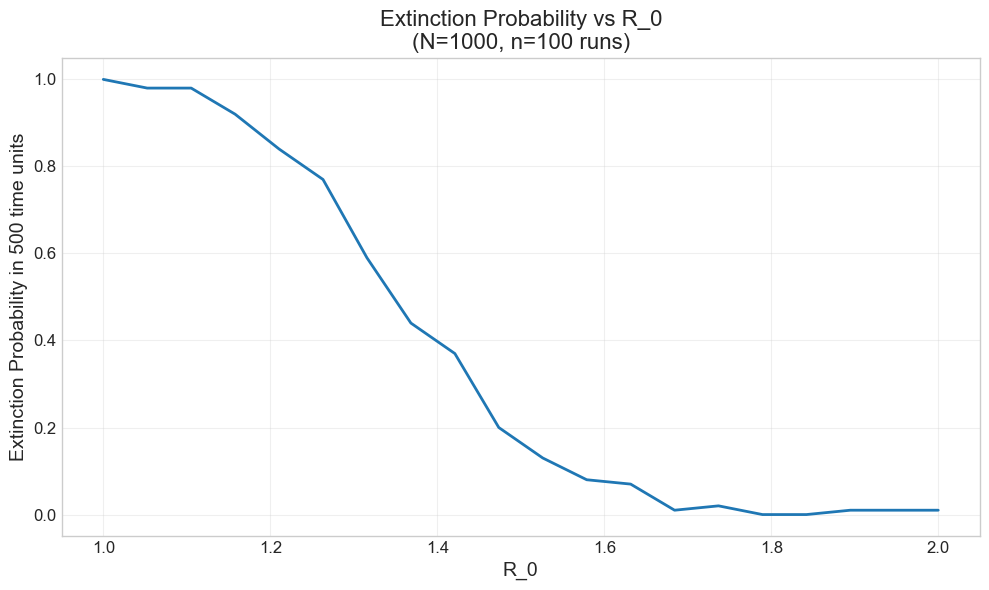

In [12]:
# We create a range of R_0 values (> 1) by varying beta keeping gamma and mu fixed
R0 = np.linspace(1, 2, 20)
gamma = 0.1
mu = 1/50
beta = [R0_i * (gamma + mu) for R0_i in R0]
N = 1000
X0 = np.round(0.05*N)
Y0 = N - X0
Z0 = 0
seed0 = 42

# Create an experiment that runs the gillespie simulation for the differnt R_0 values each n times for statistical significance. Per simulation count the number of extinctions, and the time to extiction. Take the averages over the runs and plot them against the values of R_0

n_runs = 100 # Number of simulations per R0 value
tmax = 500.0  # Maximum simulation time

# Storage for results
mean_extinction_counts = []
mean_extinction_times = []


for idx, (R0_val, beta_val) in enumerate(zip(R0, beta)):
    extinctions = []
    extinction_times = []
    
    for run in range(n_runs):
        rng = np.random.default_rng(seed=seed0+run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta_val, gamma, mu, N, X0, Y0, Z0, tmax=tmax, rng=rng
        )
        
        # Check if extinction occurred (Y reached 0 before tmax)
        extinction_idx = np.where(Y_hist == 0)[0]

        if len(extinction_idx) > 0:
            extinctions.append(1)
        else: 
            extinctions.append(0)

    mean_extinction_counts.append(np.mean(extinctions))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(R0, mean_extinction_counts, linewidth=2)
ax.set_xlabel('R_0')
ax.set_ylabel('Extinction Probability in 500 time units')
ax.set_title(f'Extinction Probability vs R_0\n(N={N}, n={n_runs} runs)')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()


In [24]:
# We create a range of R_0 values (> 1) by varying beta keeping gamma and mu fixed
R0 = 1.3
gamma = 0.1
mu = 1/50
beta = R0 * (gamma + mu)
N = np.linspace(500, 6000, 20, dtype=int)
X0 = 50
Y0 = [N_val - X0 for N_val in N]
Z0 = 0
seed0 = 42

# Create an experiment that runs the gillespie simulation for the differnt R_0 values each n times for statistical significance. Per simulation count the number of extinctions, and the time to extiction. Take the averages over the runs and plot them against the values of R_0

n_runs = 100 # Number of simulations per R0 value
tmax = 500.0  # Maximum simulation time

# Storage for results
mean_extinction_counts = []
mean_extinction_times = []


for idx, (N_val, Y0_val) in enumerate(zip(N, Y0)):
    extinctions = []
    extinction_times = []
    
    for run in range(n_runs):
        rng = np.random.default_rng(seed=seed0+run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N_val, X0, Y0_val, Z0, tmax=tmax, rng=rng
        )
        
        # Check if extinction occurred (Y reached 0 before tmax)
        extinction_idx = np.where(Y_hist == 0)[0]

        if len(extinction_idx) > 0:
            extinctions.append(1)
        else: 
            extinctions.append(0)

    mean_extinction_counts.append(np.mean(extinctions))

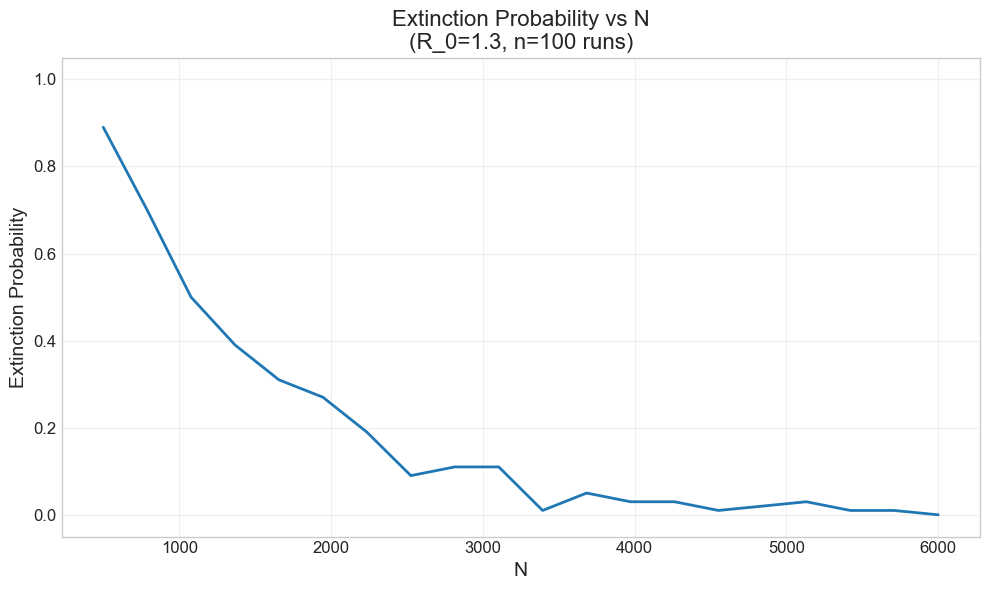

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(N, mean_extinction_counts, linewidth=2)
ax.set_xlabel('N')
ax.set_ylabel('Extinction Probability')
ax.set_title(f'Extinction Probability vs N\n(R_0={R0}, n={n_runs} runs)')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

In [ ]:
from joblib import Parallel, delayed

def run_parameter_combination(R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed):
    """
    Run simulations for a single (R0, N) parameter combination.
    Returns extinction probability for that combination.
    """
    extinctions = []
    Y0_val = N_val - X0
    Z0_val = 0
    
    for run in range(n_runs):
        # Use unique seed for each run
        seed = base_seed + run * 10000
        rng = np.random.default_rng(seed=seed)
        
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta_val, gamma, mu, N_val, X0, Y0_val, Z0_val, tmax=tmax, rng=rng
        )
        
        # Check if extinction occurred (Y reached 0 before tmax)
        extinction_idx = np.where(Y_hist == 0)[0]
        
        if len(extinction_idx) > 0:
            extinctions.append(1)
        else: 
            extinctions.append(0)
    
    return np.mean(extinctions)

# Create heatmap of extinction probabilities varying N and R0 - JOBLIB VERSION
gamma = 0.1
mu = 1/50
seed0 = 42

# Define parameter ranges
N_values = np.linspace(500, 5000, 10, dtype=int)  # Population sizes
R0_values = np.linspace(1, 2, 10)  # R0 values
beta_values = [R0_val * (gamma + mu) for R0_val in R0_values]

# Fixed parameters
X0 = 50  # Initial infected
tmax = 500.0  # Maximum simulation time
n_runs = 50  # Runs per parameter combination

# Prepare parameter combinations for joblib
param_combinations = []
combo_id = 0

for i, R0_val in enumerate(R0_values):
    beta_val = beta_values[i]
    for j, N_val in enumerate(N_values):
        # Create unique base seed for each parameter combination
        base_seed = seed0 + combo_id * 1000
        
        param_combinations.append((i, j, R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed))
        combo_id += 1

# Run multiprocessing with joblib

# Use joblib with all available cores and progress tracking
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_parameter_combination)(R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed) for i, j, R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed in param_combinations
)

# Reconstruct heatmap from results
extinction_heatmap = np.zeros((len(R0_values), len(N_values)))

for (i, j, *_), result in zip(param_combinations, results):
    extinction_heatmap[i, j] = result



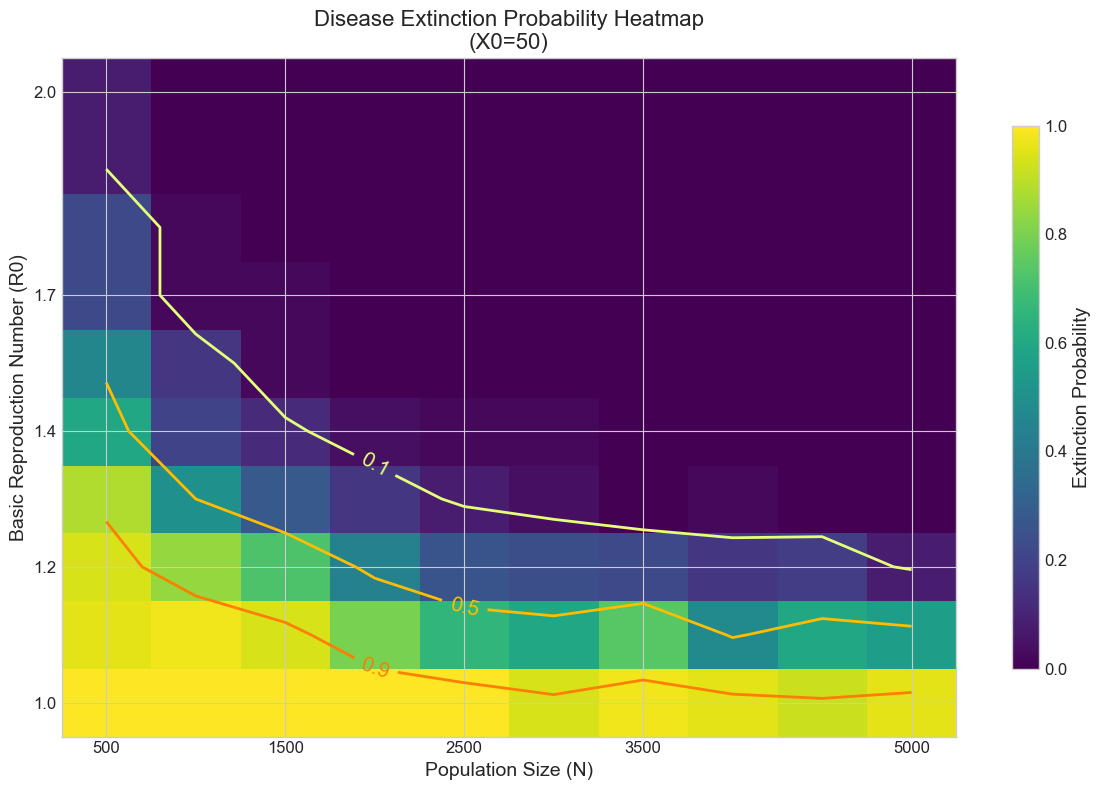

In [62]:
# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(extinction_heatmap, 
               cmap='viridis',  
               aspect='auto',
               origin='lower',
               vmin=0, vmax=1)

# Set ticks and labels
n_ticks = 5
r0_tick_indices = np.linspace(0, len(R0_values)-1, n_ticks, dtype=int)
n_tick_indices = np.linspace(0, len(N_values)-1, n_ticks, dtype=int)

ax.set_xticks(n_tick_indices)
ax.set_xticklabels([f'{N_values[i]:.0f}' for i in n_tick_indices])
ax.set_yticks(r0_tick_indices)
ax.set_yticklabels([f'{R0_values[i]:.1f}' for i in r0_tick_indices])

# Labels and title
ax.set_xlabel('Population Size (N)')
ax.set_ylabel('Basic Reproduction Number (R0)')
ax.set_title(f'Disease Extinction Probability Heatmap\n(X0={X0})')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Extinction Probability')

# Add contour lines for specific extinction probabilities
contour_levels = [0.1, 0.5, 0.9]
contours = ax.contour(extinction_heatmap, levels=contour_levels, cmap='Wistia', linewidths=2)
ax.clabel(contours, inline=True, fontsize=15, fmt='%.1f')

plt.tight_layout()
plt.show()